In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, gmres
import matplotlib.pyplot as plt
import time

### 常系数扩散方程
考虑扩散方程：
$$
\partial_t u = \alpha \Delta u
$$

一维扩散方程的显式格式：
$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\alpha \frac{u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}
$$
​
在Dirichlet边界条件下：
​
$$
\left[\begin{array}{c}
\mathrm{u}_{1}^{n+1} \\
\mathrm{u}_{2}^{n+1} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n+1} \\
\mathrm{u}_{\mathrm{J}}^{n+1}
\end{array}\right] = 
\left[\begin{array}{ccccccc}
 a_2 & a_3 & & &  \\
  a_1 & a_2 & a_3 & & \\
 & \ddots & \ddots & \ddots &  \\
 & & a_1 & a_2 & a_3 \\
 & & & a_1 & a_2  
\end{array}\right]
\left[\begin{array}{c}
\mathrm{u}_{1}^{n} \\
\mathrm{u}_{2}^{n} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n} \\
\mathrm{u}_{\mathrm{J}}^{n}
\end{array}\right]
$$
​
其中$a_2 = 1-\dfrac{2\alpha \Delta t}{\Delta x^2}, a_1 = a_3 = \dfrac{\alpha \Delta t}{\Delta x^2}$


一维扩散方程的隐式格式：
$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\alpha \frac{u_{i+1}^{n+1}-2 u_{i}^{n+1}+u_{i-1}^{n+1}}{\Delta x^{2}}
$$

其中$a_2 = 1+\dfrac{2\alpha \Delta t}{\Delta x^2}, a_1 = a_3 = -\dfrac{\alpha \Delta t}{\Delta x^2}$

在Dirichlet边界条件下：

$$
\left[\begin{array}{ccccccc}
 a_2 & a_3 & & &  \\
  a_1 & a_2 & a_3 & & \\
 & \ddots & \ddots & \ddots &  \\
 & & a_1 & a_2 & a_3 \\
 & & & a_1 & a_2  
\end{array}\right]
\left[\begin{array}{c}
\mathrm{u}_{1}^{n+1} \\
\mathrm{u}_{2}^{n+1} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n+1} \\
\mathrm{u}_{\mathrm{J}}^{n+1}
\end{array}\right] = 
\left[\begin{array}{c}
\mathrm{u}_{1}^{n} \\
\mathrm{u}_{2}^{n} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n} \\
\mathrm{u}_{\mathrm{J}}^{n}
\end{array}\right]
$$

写成矩阵形式$Au^{n+1} = u^{n}$

则$u^{n+1} = A^{-1}u^{n}$

alpha:1.000, dx: 0.010, dt:0.000


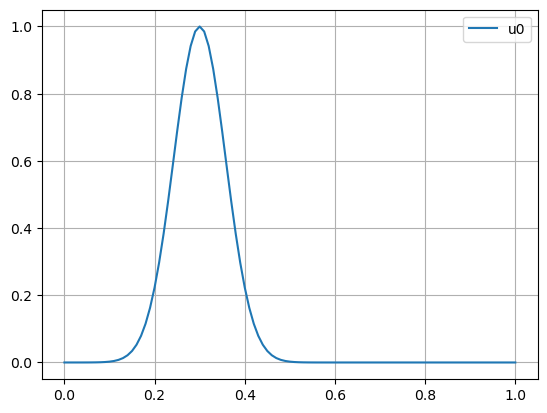

In [24]:
### 计算 alpha = 1
alpha = 1
x = np.linspace(0, 1,101)
u0 = np.exp(-150*(x-0.3)**2)
Nx = u0.shape[0]
dx = x[1] - x[0]
dt = 0.00001
print("alpha:%.3f, dx: %.3f, dt:%.3f"%(alpha, dx, dt))

plt.plot(x, u0, label="u0")
plt.legend()
plt.grid()

In [25]:
A_diag = np.ones((Nx,))*2
A_up = np.ones((Nx,))*3
A_off = np.ones((Nx,))*1
A = scipy.sparse.spdiags(A_diag, 0, Nx, Nx)\
        +scipy.sparse.spdiags(A_up, 1, Nx, Nx)\
        +scipy.sparse.spdiags(A_off, -1, Nx, Nx)
print(A.toarray())

[[2. 3. 0. ... 0. 0. 0.]
 [1. 2. 3. ... 0. 0. 0.]
 [0. 1. 2. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 3. 0.]
 [0. 0. 0. ... 1. 2. 3.]
 [0. 0. 0. ... 0. 1. 2.]]


In [26]:
def diffusion_explicit(alpha, dt, dx, Nx):
    a1 = alpha*dt/dx**2
    a3 = alpha*dt/dx**2
    a2 = 1 - 2*alpha*dt/dx**2
    A_diag = np.ones((Nx,))*a2
    A_up = np.ones((Nx,))*a3
    A_off = np.ones((Nx,))*a1
    A =  scipy.sparse.spdiags(A_diag, 0, Nx, Nx)\
        +scipy.sparse.spdiags(A_up, 1, Nx, Nx)\
        +scipy.sparse.spdiags(A_off, -1, Nx, Nx)
    return A

In [27]:
CFL = alpha*dt/dx**2

Text(0.5, 1.0, 'Explicit, CFL=0.10')

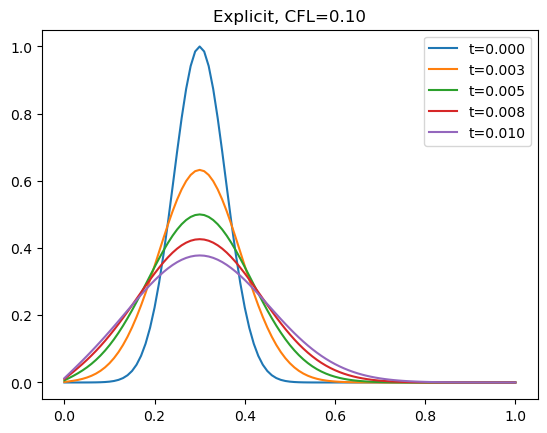

In [28]:
Nt = 1000
T = dt * Nt
sol = np.zeros((Nt,Nx))
sol[0,:] = u0
for ti in range(1,Nt):
    sol[ti,:] = diffusion_explicit(alpha, dt, dx, Nx)@sol[ti-1,:]
for ti in [0, int(Nt/4), int(2*Nt/4), int(3*Nt/4), Nt-1]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('Explicit, CFL=%.2f'%CFL)

介绍一下gmres：

In [29]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres
A = csc_matrix([[3, 2, 0], [1, -1, 0], [0, 5, 1]], dtype=float)
b = np.array([2, 4, -1], dtype=float)
x, exitCode = gmres(A, b, atol=1e-5)

In [32]:
A.toarray()

array([[ 3.,  2.,  0.],
       [ 1., -1.,  0.],
       [ 0.,  5.,  1.]])

In [34]:
b

array([ 2.,  4., -1.])

In [35]:
A@x

array([ 2.,  4., -1.])

介绍一下 LinearOperator

$x=[x_1,x_2,x_3]$ 经过线性变换 $Ax$ 之后，变为 $y:$
$$
y=[x_1+2x_2+3x_3,
    4x_1+5x_2+3x_3,
    7x_1+8x_2+9x_3]
$$

LinOperator可以帮助我们得到线性变换 A .

In [36]:
from scipy.sparse.linalg import LinearOperator

In [37]:
def linertransform(x):
    y = np.zeros((x.shape[0],))
    y[0] = x[0]+2*x[1]+3*x[2]
    y[1] = 4*x[0]+5*x[1]+6*x[2]
    y[2] = 7*x[0]+8*x[1]+9*x[2]
    return y

In [38]:
A = LinearOperator((3,3), linertransform)

In [42]:
x = [1,2,3]
A@x

array([14., 32., 50.])

\begin{align}
&14 = 1+2*2+3*3\\
&32 = 4*1+5*2+6*3\\
&50 = 7*1+8*2+9*3
\end{align}


在得到了线性变换 A 后，我们可以用 grmes 求解 Ax=b.

In [43]:
b = [14,32,50]
x, exitCode = gmres(A, b)

In [45]:
x

array([1., 2., 3.])

In [46]:
def diffusion_implict(alpha, dt, dx, Nx):
    a1 = -alpha*dt/dx**2
    a3 = -alpha*dt/dx**2
    a2 = 1+2*alpha*dt/dx**2
    A_diag = np.ones((Nx,))*a2
    A_up = np.ones((Nx,))*a3
    A_off = np.ones((Nx,))*a1
    A = scipy.sparse.spdiags(A_diag, 0, Nx, Nx)\
        +scipy.sparse.spdiags(A_up, 1, Nx, Nx)\
        +scipy.sparse.spdiags(A_off, -1, Nx, Nx)
    return A

In [56]:
alpha = 1
x = np.linspace(0, 1,101)
u0 = np.exp(-150*(x-0.3)**2)
Nx = u0.shape[0]
dx = x[1] - x[0]
dt = 0.0001
CFL = alpha*dt/dx**2
Nt = 100
T = dt * Nt
sol = np.zeros((Nt,Nx))
sol[0,:] = u0
A = diffusion_implict(alpha, dt, dx, Nx)
A = csc_matrix(A)
for ti in range(1,Nt):
    sol[ti,:] = scipy.sparse.linalg.spsolve(A, sol[ti-1,:])

Text(0.5, 1.0, 'Explicit, CFL=1.00')

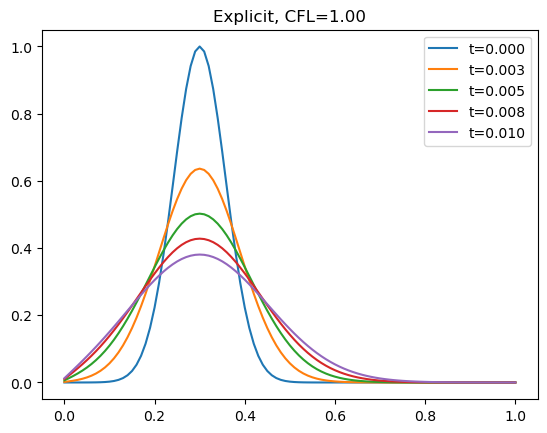

In [57]:
for ti in [0, int(Nt/4), int(2*Nt/4), int(3*Nt/4), Nt-1]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('Explicit, CFL=%.2f'%CFL)

### 常系数对流扩散方程
对于一般的对流扩散方程：
$$
u_t + \beta u_x = \alpha u_{xx}
$$

显式格式+迎风格式：
$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t} + \max\{\beta,0\} \frac{u_i^{n} - u_{i-1}^{n}}{\Delta x} + \min\{\beta,0\} \frac{u_{i+1}^{n} - u_{i}^{n}}{\Delta x}=\alpha \frac{u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}
$$

合并同类项：

$$
u_{i}^{n+1} = a_1 u_{i-1}^{n} + a_2 u_{i}^{n} + a_3 u_{i+1}^{n}
$$
$$
a_1 = \max\{\beta,0\}\frac{\Delta t}{\Delta x} + \alpha\frac{\Delta t}{\Delta x^2}
, \quad
a_2 = 1 - \max\{\beta,0\}\frac{\Delta t}{\Delta x} + \min\{\beta,0\}\frac{\Delta t}{\Delta x} - 2\alpha\frac{\Delta t}{\Delta x^2}
, \quad
a_3 = -\min\{\beta,0\}\frac{\Delta t}{\Delta x} + \alpha\frac{\Delta t}{\Delta x^2}
$$
于是，我们可以有
$$
u^{n+1} = Au^n
$$

隐式格式+迎风格式：
$$
\frac{u_{i}^{n}-u_{i}^{n-1}}{\Delta t} + \max\{\beta,0\} \frac{u_i^{n} - u_{i-1}^{n}}{\Delta x} + \min\{\beta,0\} \frac{u_{i+1}^{n} - u_{i}^{n}}{\Delta x}=\alpha \frac{u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}
$$
可以得到：
$$
u_i^{n-1}=(\frac{\Delta t\alpha}{\Delta x^{2}}-\frac{\Delta t}{\Delta x}\max\{\beta, 0\})u^n_{i-1}+(1+\frac{\Delta t}{\Delta x}\max\{\beta,0\}-\frac{\Delta t}{\Delta x}\min\{\beta,0\}-\frac{2\Delta t\alpha}{\Delta x^2})u_i^n+(\frac{\Delta t}{\Delta x}\min\{\beta,0\}+\frac{\Delta t\alpha}{\Delta x^2})u_{i+1}^n
$$

例子中，我们令$\alpha=0.1,\beta=0$。

alpha:0.100, beta:0.000, dx: 0.010, dt:0.010


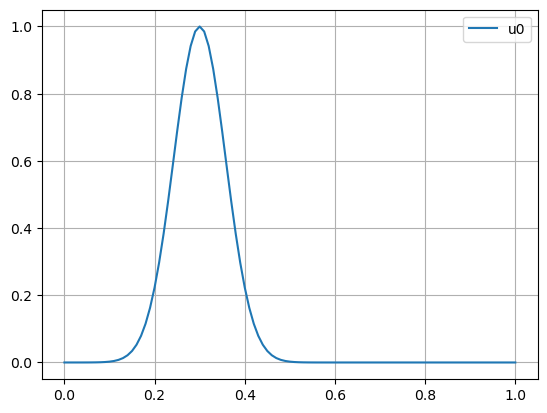

In [7]:
alpha = 0.1
beta = 0.0
x = np.linspace(0, 1,101)
u0 = np.exp(-150*(x-0.3)**2)
Nx = u0.shape[0]
dx = x[1] - x[0]
dt = 0.01
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.3f"%(alpha, beta, dx, dt))

plt.plot(x, u0, label="u0")
plt.legend()
plt.grid()

In [8]:
def RHSMatrix(alpha, beta, dx, dt, Nx, bc):
    # Nx: number of grid points in domain
    # bc: boundary condition
    a1 = max(beta,0)*dt/dx + alpha*dt/dx**2
    a2 = 1 - max(beta,0)*dt/dx + min(beta,0)*dt/dx - 2*alpha*dt/dx**2
    a3 = -min(beta,0)*dt/dx + alpha*dt/dx**2
    if bc == "Neumann":
        print("using Neumann boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
        A[0,1] += a1
        A[-1,-2] += a3
    elif bc == "Periodic":
        print("using Periodic boundary")
        A = csr_matrix(diags([a3, a1, a2, a3, a1],[1-Nx,-1,0,1,Nx-1], shape=(Nx,Nx)))
    else:
        print("using Dirichlet boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
    return A

In [9]:
def implict(alpha, beta, dx, dt, Nx, bc):
    a1 = -alpha*dt/dx**2 - max(beta,0)*dt/dx  
    a2 = 1 + max(beta,0)*dt/dx - min(beta,0)*dt/dx + 2*alpha*dt/dx**2
    a3 = min(beta,0)*dt/dx - alpha*dt/dx**2
    if bc == "Neumann":
        print("using Neumann boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
        A[0,1] += a1
        A[-1,-2] += a3
    elif bc == "Periodic":
        print("using Periodic boundary")
        A = csr_matrix(diags([a3, a1, a2, a3, a1],[1-Nx,-1,0,1,Nx-1], shape=(Nx,Nx)))
    else:
        print("using Dirichlet boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
    return A

CFL=0.5时候，我们这里使用显示格式：

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
using Periodic boundary
耗时: 0.09179秒


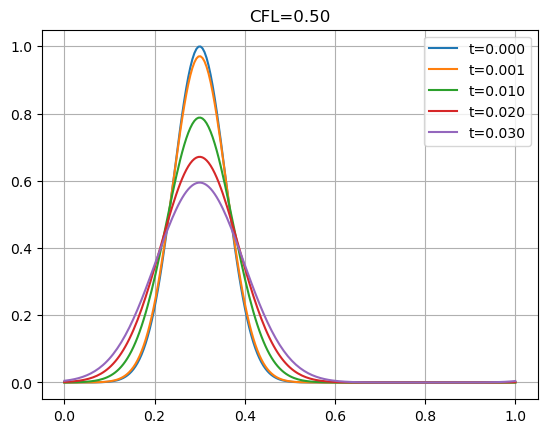

In [10]:
time_start = time.time()
CFL = 0.5
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
A = RHSMatrix(alpha, beta, dx, dt, Nx, bc="Periodic")
Nt = 300
tst = Nt*dt

sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0

for ti in range(Nt):
    sol[ti+1,:] = A @ sol[ti,:]

for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()
print("耗时: {:.5f}秒".format(time.time() - time_start))

Text(0.5, 0.5, 't')

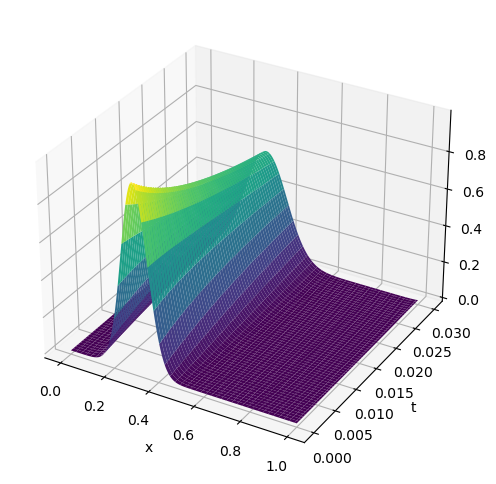

In [11]:
### plot 3D 
t = np.linspace(0, tst, Nt)
x = np.linspace(x0, xst, Nx)
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
X,T = np.meshgrid(x,t)
surface = ax.plot_surface(X, T, sol[1:], cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')

CFL=0.6 时候，我们发现显示格式不能使用

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
using Periodic boundary


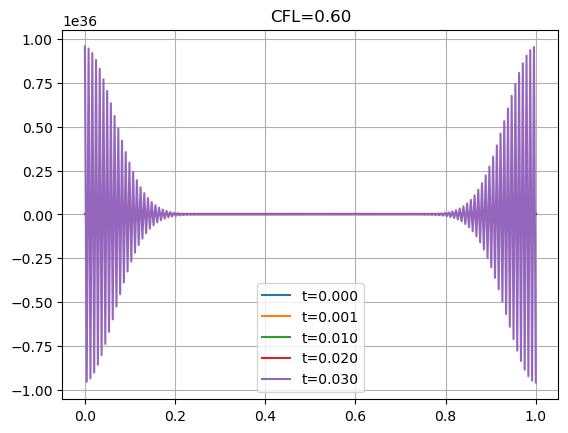

In [12]:
CFL = 0.6
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
A = RHSMatrix(alpha, beta, dx, dt, Nx, bc="Periodic")
Nt = 300
T = Nt*dt

sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0

for ti in range(Nt):
    sol[ti+1,:] = A @ sol[ti,:]

for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()

CFL=0.6 时，隐式格式依旧有效

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
using Dirichlet boundary


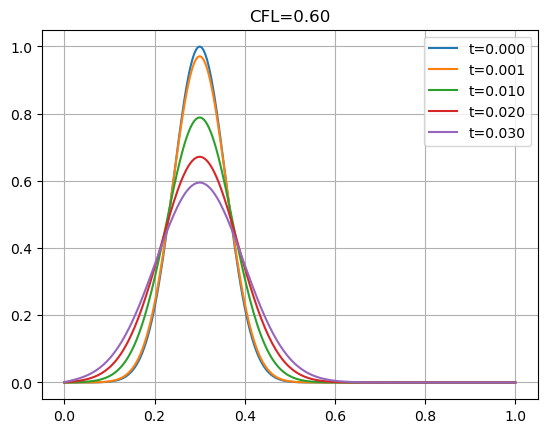

In [13]:
CFL = 0.6
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
A = implict(alpha, beta, dx, dt, Nx, bc="dd").toarray()

A = np.linalg.inv(A)
Nt = 300
T = Nt*dt

sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0

for ti in range(Nt):
    sol[ti+1,:] = A @ sol[ti,:]

for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()

### 使用循环的方法（不推荐）

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
耗时: 0.11689秒


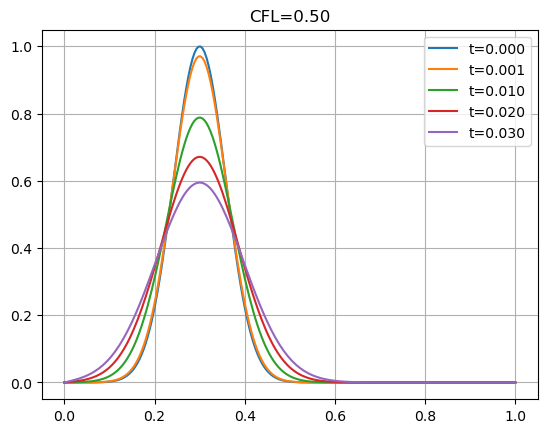

In [14]:
time_start = time.time()
CFL = 0.5
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
Nt = 300
tst = Nt*dt

a1 = max(beta,0)*dt/dx + alpha*dt/dx**2
a2 = 1 - max(beta,0)*dt/dx + min(beta,0)*dt/dx - 2*alpha*dt/dx**2
a3 = -min(beta,0)*dt/dx + alpha*dt/dx**2
sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0
for ti in range(Nt):
    for xi in range(1,Nx-1):
        sol[ti+1,xi] = a1*sol[ti,xi-1]+a2*sol[ti,xi]+a3*sol[ti,xi+1]
    sol[ti+1,0] = 0
    sol[ti+1,-1] = 0
for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()
print("耗时: {:.5f}秒".format(time.time() - time_start))

使用这种循环的方法，耗时0.06984s;但是采用矩阵的方式，只需要0.01496秒